In [1]:
# Verify that key libraries are installed correctly
import pandas as pd
import numpy as np
import mlflow
import langchain
import faiss
from sentence_transformers import SentenceTransformer

print("Libraries imported successfully!")

/Users/vijay/Desktop/Data Projects/New Resume Projects/Medical-Cost-Prediction/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


Libraries imported successfully!


In [2]:
# Step 1: Import all the tools you'll use
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Step 2: Load the data
df = pd.read_csv('insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


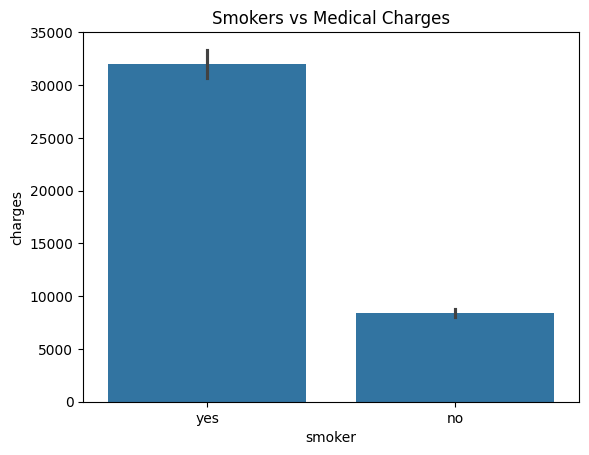

In [4]:
sns.barplot(x='smoker', y='charges', data=df)
plt.title("Smokers vs Medical Charges")
plt.savefig('Images/smokers_vs_medical_charges.png', bbox_inches='tight')
plt.show()

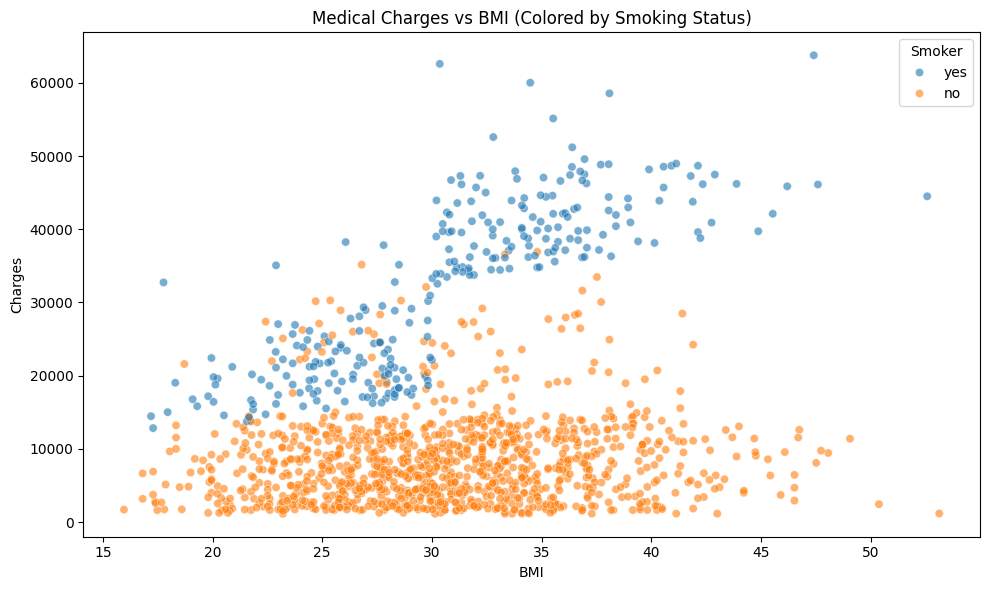

In [5]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title('Medical Charges vs BMI (Colored by Smoking Status)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.tight_layout()
plt.savefig('Images/charges_vs_bmi_smoker.png', bbox_inches='tight')
plt.show()

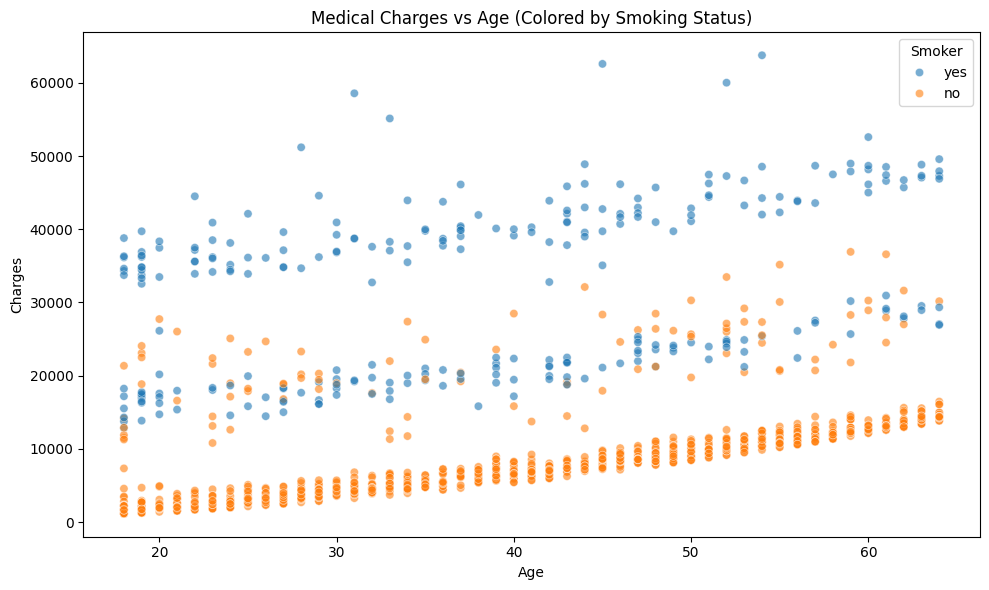

In [6]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='age', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title('Medical Charges vs Age (Colored by Smoking Status)')
plt.xlabel('Age')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.tight_layout()
plt.savefig('Images/charges_vs_age_smoker.png', bbox_inches='tight')
plt.show()

In [5]:
# Step 4: Convert categorical columns to numbersplt.figure(figsize=(10, 6))
sns.scatterplot(x='bmi', y='charges', hue='smoker', data=df, alpha=0.6)
plt.title('Medical Charges vs BMI (Colored by Smoking Status)')
plt.xlabel('BMI')
plt.ylabel('Charges')
plt.legend(title='Smoker')
plt.tight_layout()
plt.savefig('Images/charges_vs_bmi_smoker.png', bbox_inches='tight')
plt.show()

df_encoded = pd.get_dummies(df, drop_first=True)
df_encoded.head()

,age,bmi,children,charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,False,True,False,False,True
1,18,33.770,1,1725.55230,True,False,False,True,False
2,28,33.000,3,4449.46200,True,False,False,True,False
3,33,22.705,0,21984.47061,True,False,True,False,False
4,32,28.880,0,3866.85520,True,False,True,False,False


In [6]:
# Step 5: Split into inputs (X) and output (y)
X = df_encoded.drop('charges', axis=1)
y = df_encoded['charges']

In [7]:
from sklearn.model_selection import train_test_split

# Step 6: Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from sklearn.linear_model import LinearRegression

# Step 7: Train the model
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [9]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Step 8: Make predictions and evaluate
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2 Score:", r2)


RMSE: 5796.2846592762735
R2 Score: 0.7835929767120723


In [10]:
# Step 9: Export cleaned data for BI tools
df_encoded.to_csv('cleaned_insurance_data.csv', index=False)

In [7]:
%%writefile feature_engineering.py
import pandas as pd

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # BMI categories
    if 'bmi' in df.columns:
        df['BMI_category'] = pd.cut(
            df['bmi'],
            bins=[0, 18.5, 24.9, 29.9, float('inf')],
            labels=['underweight', 'normal', 'overweight', 'obese']
        )

    # Smoker indicator (works for encoded or raw)
    if 'smoker' in df.columns:
        df['is_smoker'] = (df['smoker'] == 'yes').astype(int)
    elif 'smoker_yes' in df.columns:
        df['is_smoker'] = df['smoker_yes']
    else:
        df['is_smoker'] = 0

    # Diabetic indicator (optional, if column exists)
    if 'diabetic' in df.columns:
        df['is_diabetic'] = (df['diabetic'] == 'yes').astype(int)
    else:
        df['is_diabetic'] = 0

    # Region indicators (if not already encoded)
    if 'region' in df.columns:
        region_dummies = pd.get_dummies(df['region'], prefix='region')
        df = pd.concat([df, region_dummies], axis=1)

    return df

Overwriting feature_engineering.py


In [4]:
import os
print("feature_engineering.py" in os.listdir())

True


In [8]:
import pandas as pd
from feature_engineering import add_features

df = pd.read_csv('cleaned_insurance_data.csv')
df_features = add_features(df)
df_features.head()

KeyError: 'smoker'

In [6]:
import pandas as pd
df = pd.read_csv('cleaned_insurance_data.csv')
print(df.columns)

Index(['age', 'bmi', 'children', 'charges', 'sex_male', 'smoker_yes',
       'region_northwest', 'region_southeast', 'region_southwest'],
      dtype='object')
